In [42]:
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.pipeline import make_pipeline

In [43]:
df = pd.read_csv('../../Data/Merged_Data/final_data.csv.zip')
df_with_sponsors = pd.read_csv('../../Data/Merged_Data/final_data_with_sponsors.csv.zip')

# Splitting Data into Train and Test 

In [44]:
X = df[['title', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

In [45]:
df['law_enacted'].value_counts(normalize=True)

0    0.796322
1    0.203678
Name: law_enacted, dtype: float64

# Metrics Function

In [46]:
def my_metrics(estimator, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    
    train_preds = estimator.predict(X_train)
    preds = estimator.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_preds)
    train_recall = recall_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    
    print(f'Train Accuracy: {train_acc}')
    print(f'Train Recall: {train_recall}')
    print(f'Test Accuracy: {test_acc}')
    print(f'Test Recall: {recall}')
    print(f'Test Precision: {precision}')
    print()
    print(f'Test Confusion Matrix:')
    
    ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)
    
    return {
        'accuracy': test_acc,
        'recall': recall,
        'precision': precision
    }

In [47]:
#List that will keep track of metrics
history = []

In [48]:
#For column transformers later
word_feature = 'title'
party_features = ['gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']

# Baseline Model

This model is one that guesses that the bill will not pass for every bill.

In [49]:
df['law_enacted'].value_counts(normalize = True)

0    0.796322
1    0.203678
Name: law_enacted, dtype: float64

This model has 79.6% accuracy

# Simple CV with Logit
**Strategy:**
First model will be kept simple:

    -CountVectorize title
    -OneHotEncode categorical variables
    -Logistic Regression

In [50]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe = Pipeline([
    ('pre', preprocess),
    ('logit', LogisticRegression(max_iter=1000))
])

logit_pipe.fit(X_train, y_train);

Train Accuracy: 0.8667313239828907
Train Recall: 0.43526036261522494
Test Accuracy: 0.8286023350367414
Test Recall: 0.3498168498168498
Test Precision: 0.6463620981387479

Test Confusion Matrix:


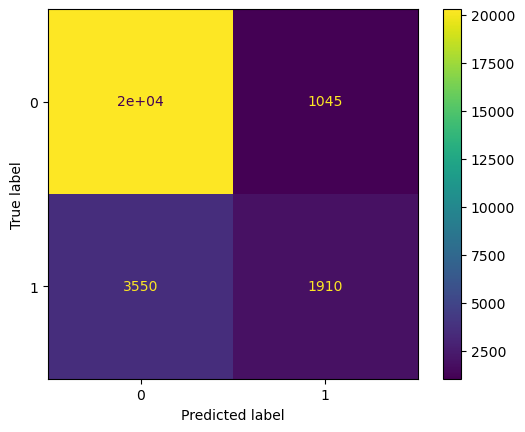

In [51]:
history.append(my_metrics(logit_pipe))

The test accuracy for this model is 82.8% accuracy, better than our base model but not by too much. It seems to slighly over fit as the training accuracy is 3% higher. Our recall and precision are not veery impressive.

# Lemmatize title CV with Logit
**Strategy:**
Second model will be kept simple:

    -WordNetLemmatize titles before word count vectorizing
    -CountVectorize title
    -OneHotEncode categorical variables
    -Logistic Regression
    
Lemmatizing is the act of bring words down to their base. So a word like cats becomes cat.

In [52]:
#Making column for the Title lemmatized
wnl = WordNetLemmatizer()
df['lemma_title'] = df['title'].map(lambda x:' '.join([wnl.lemmatize(word) for word in word_tokenize(x)]))

word_feature = 'lemma_title'

In [53]:
#Have to resplit as we are using a new colum. Same random state makes it the same sample for the train and test
X = df[['lemma_title', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

In [54]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder())
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_lemma = Pipeline([
    ('pre', preprocess),
    ('logit', LogisticRegression(max_iter=1000))
])

logit_pipe_lemma.fit(X_train, y_train);

Train Accuracy: 0.8655749527504227
Train Recall: 0.427263292839265
Test Accuracy: 0.8300943712932224
Test Recall: 0.34285714285714286
Test Precision: 0.6593871081366678

Test Confusion Matrix:


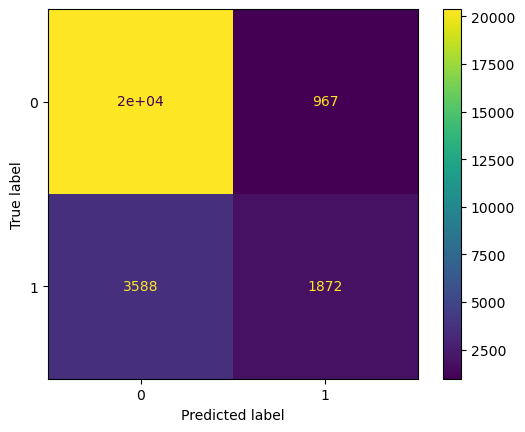

In [55]:
history.append(my_metrics(logit_pipe_lemma,X_train, X_test, y_train, y_test))

In [56]:
pd.DataFrame(history, index = ['cv_logit', 'cv_lemma_logit'])

,accuracy,recall,precision
cv_logit,0.828602,0.349817,0.646362
cv_lemma_logit,0.830094,0.342857,0.659387


Lemmatizing did not improve the model significantly. Although, the precision improved and the rcall became worse.

# Porter Stem title CV with Logit
**Strategy:**
Second model will be kept simple:

    -Porter Stemming titles before word count vectorizing
    -CountVectorize title
    -OneHotEncode categorical variables
    -Logistic Regression
    
Stemming is like lemmatizing but more extreme. Words like computational or compute or computes become comput.

In [57]:
#Making column for the Titles stemmed
ps = PorterStemmer()
df['stemmed_title'] = df['title'].map(lambda x:' '.join([ps.stem(word) for word in word_tokenize(x)]))

word_feature = 'stemmed_title'

In [58]:
#Have to resplit as we are using a new colum. Same random state makes it the same sample for the train and test
X = df[['stemmed_title', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

In [59]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder())
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_stemmed = Pipeline([
    ('pre', preprocess),
    ('logit', LogisticRegression(max_iter=1000))
])

logit_pipe_stemmed.fit(X_train, y_train);

Train Accuracy: 0.8564980602805132
Train Recall: 0.3833709785727367
Test Accuracy: 0.8275952105636167
Test Recall: 0.3194139194139194
Test Precision: 0.6581132075471698

Test Confusion Matrix:


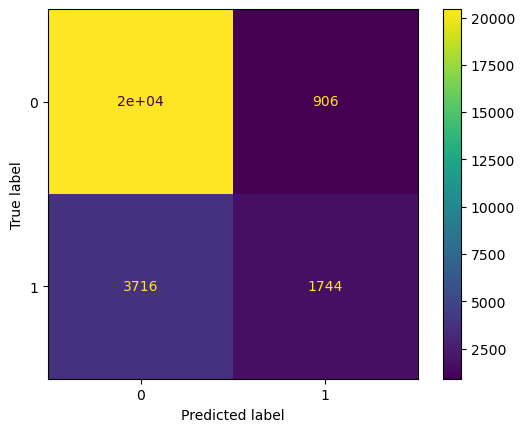

In [60]:
history.append(my_metrics(logit_pipe_stemmed,X_train, X_test, y_train, y_test))

In [61]:
pd.DataFrame(history, index = ['cv_logit', 'cv_lemma_logit', 'cv_stem_logit'])

,accuracy,recall,precision
cv_logit,0.828602,0.349817,0.646362
cv_lemma_logit,0.830094,0.342857,0.659387
cv_stem_logit,0.827595,0.319414,0.658113


Stemming did not help the model.

# TFIDF with Logit
**Strategy:**
Second model will be kept simple:

    -TFIDF title
    -OneHotEncode categorical variables
    -Logistic Regression
    
Stemming is like lemmatizing but more extreme. Words like computational or compute or computes become comput.

In [62]:
X = df[['title', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

word_feature = 'title'

Train Accuracy: 0.846165323783945
Train Recall: 0.3229351077467798
Test Accuracy: 0.8347569845947257
Test Recall: 0.29816849816849816
Test Precision: 0.7313566936208445

Test Confusion Matrix:


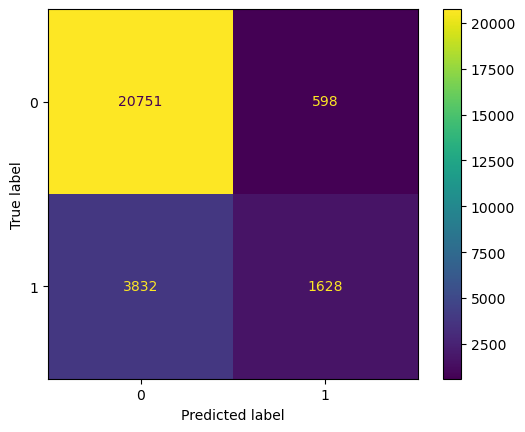

In [63]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder())
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('tfidf', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_tfidf = Pipeline([
    ('pre', preprocess),
    ('logit', LogisticRegression(max_iter=1000))
])

logit_pipe_tfidf.fit(X_train, y_train)

history.append(my_metrics(logit_pipe_tfidf,X_train, X_test, y_train, y_test));

In [64]:
pd.DataFrame(history, index = ['cv_logit', 'cv_lemma_logit', 'cv_stem_logit', 'tfidif_logit'])

,accuracy,recall,precision
cv_logit,0.828602,0.349817,0.646362
cv_lemma_logit,0.830094,0.342857,0.659387
cv_stem_logit,0.827595,0.319414,0.658113
tfidif_logit,0.834757,0.298168,0.731357


Worst recall but best accuracy. Also pretty high prcision. The recall is just so darn low.

# CV with Logit and SMOTE oversampling
**Strategy:**
Second model will be kept simple:

    -Cvec title
    -OneHotEncode categorical variables
    -SMOTE oversampling
    -Logistic Regression
    
SMOTE: Synthetic Minority Over-sampling Technique (SMOTE)

Train Accuracy: 0.8223415895752512
Train Recall: 0.78694829375496
Test Accuracy: 0.7522473796113246
Test Recall: 0.634981684981685
Test Precision: 0.427180877279448

Test Confusion Matrix:


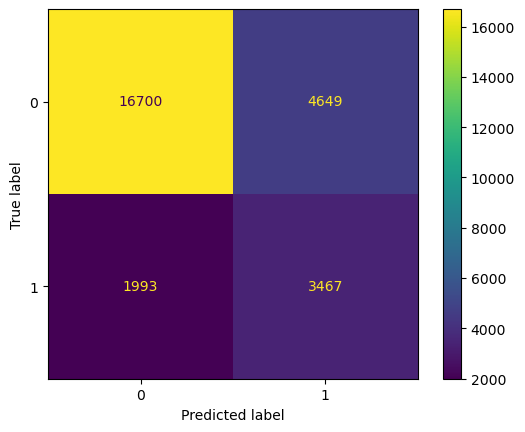

In [65]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_smote = make_pipeline(preprocess, SMOTE(random_state = 42), LogisticRegression(max_iter=1000))

logit_pipe_smote.fit(X_train, y_train)

history.append(my_metrics(logit_pipe_smote,X_train, X_test, y_train, y_test));

In [66]:
pd.DataFrame(history, index = ['cv_logit', 'cv_lemma_logit', 'cv_stem_logit', 'tfidif_logit', 'cv_SMOTE_logit'])

,accuracy,recall,precision
cv_logit,0.828602,0.349817,0.646362
cv_lemma_logit,0.830094,0.342857,0.659387
cv_stem_logit,0.827595,0.319414,0.658113
tfidif_logit,0.834757,0.298168,0.731357
cv_SMOTE_logit,0.752247,0.634982,0.427181


Worst accuracy yet, but not significantly worse compared to the increase in recall! Although the accuracy is loweer than the baseline, I would say this is the beest model yet.

# CV with Logit and random oversampling
**Strategy:**
Second model will be kept simple:

    -Cvec title
    -OneHotEncode categorical variables
    -Random oversampling
    -Logistic Regression
    

Train Accuracy: 0.8219188301999403
Train Recall: 0.8263231792930834
Test Accuracy: 0.7469879518072289
Test Recall: 0.6490842490842491
Test Precision: 0.42135299013197003

Test Confusion Matrix:


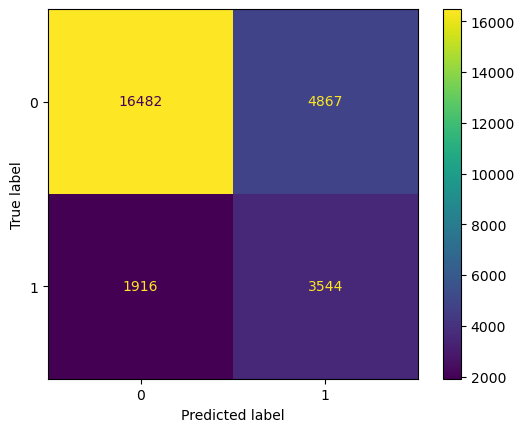

In [68]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_ROS = make_pipeline(preprocess, RandomOverSampler(random_state = 42), LogisticRegression(max_iter=1000))

logit_pipe_ROS.fit(X_train, y_train)

history.append(my_metrics(logit_pipe_ROS,X_train, X_test, y_train, y_test));

In [69]:
pd.DataFrame(history, index = ['cv_logit', 'cv_lemma_logit', 'cv_stem_logit', 'tfidif_logit', 'cv_SMOTE_logit', 'cv_OverSample_logit'])

,accuracy,recall,precision
cv_logit,0.828602,0.349817,0.646362
cv_lemma_logit,0.830094,0.342857,0.659387
cv_stem_logit,0.827595,0.319414,0.658113
tfidif_logit,0.834757,0.298168,0.731357
cv_SMOTE_logit,0.752247,0.634982,0.427181
cv_OverSample_logit,0.746988,0.649084,0.421353


# TFIDF with Logit and random oversampling
**Strategy:**
Second model will be kept simple:

    -TFIDF title
    -OneHotEncode categorical variables
    -Random oversampling
    -Logistic Regression
    

Train Accuracy: 0.7994752810106436
Train Recall: 0.7775471582931445
Test Accuracy: 0.7479204744675295
Test Recall: 0.6584249084249084
Test Precision: 0.4235391140433553

Test Confusion Matrix:


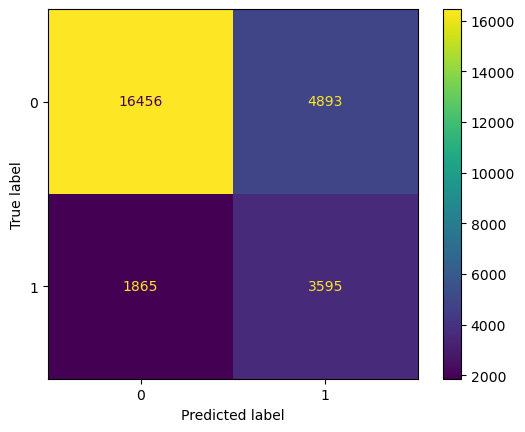

In [70]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_tfidf_smote = make_pipeline(preprocess, SMOTE(random_state = 42), LogisticRegression(max_iter=1000))

logit_pipe_tfidf_smote.fit(X_train, y_train)

history.append(my_metrics(logit_pipe_tfidf_smote,X_train, X_test, y_train, y_test));

In [71]:
pd.DataFrame(history, index = ['cv_logit', 'cv_lemma_logit', 'cv_stem_logit', 'tfidif_logit', 'cv_SMOTE_logit', 'cv_OverSample_logit', 'tfidf_SMOTE_logit'])

,accuracy,recall,precision
cv_logit,0.828602,0.349817,0.646362
cv_lemma_logit,0.830094,0.342857,0.659387
cv_stem_logit,0.827595,0.319414,0.658113
tfidif_logit,0.834757,0.298168,0.731357
cv_SMOTE_logit,0.752247,0.634982,0.427181
cv_OverSample_logit,0.746988,0.649084,0.421353
tfidf_SMOTE_logit,0.747920,0.658425,0.423539


In [50]:
subjects_df = df[df['subject'].isnull() == False]

In [51]:
X = subjects_df[['subject', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = subjects_df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

word_feature = 'subject'

In [52]:
subjects_df['law_enacted'].value_counts(normalize=True)

0    0.797436
1    0.202564
Name: law_enacted, dtype: float64

In [53]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe = Pipeline([
    ('pre', preprocess),
    ('logit', LogisticRegression(max_iter=1000))
])

logit_pipe.fit(X_train, y_train);

Train Accuracy: 0.8473894099401816
Test Recall: 0.3212723295661684
Test Accuracy: 0.8101910828025478
Balanced Accuracy: 0.5835670310603935
Recall: 0.2026251025430681

Test Confusion Matrix:


{'balanced_accuracy': 0.5835670310603935,
 'recall': 0.2026251025430681,
 'precision': 0.59185303514377,
 'f1_score': 0.3018944795273986}

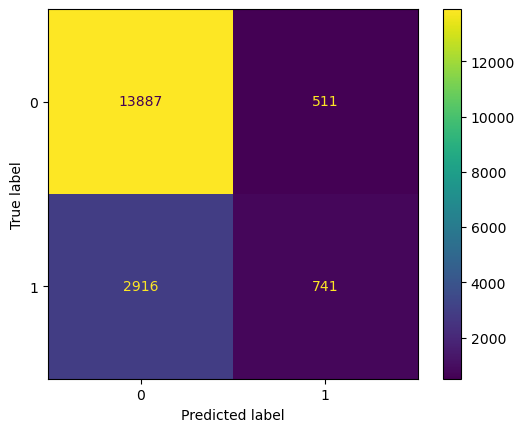

In [54]:
my_metrics(logit_pipe,X_train, X_test, y_train, y_test)

Train Accuracy: 0.7871095192378702
Test Recall: 0.8246445497630331
Test Accuracy: 0.7210744945998339
Balanced Accuracy: 0.690070511190845
Recall: 0.6379546076018594

Test Confusion Matrix:


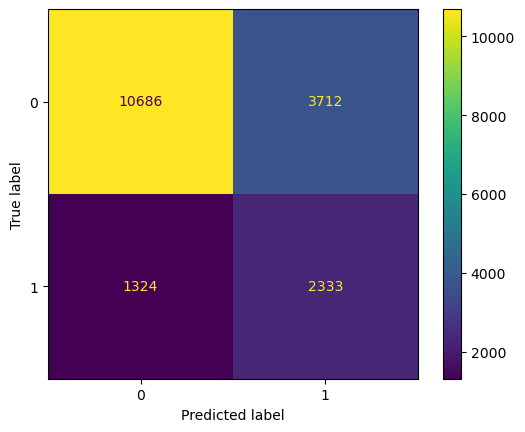

In [55]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
logit_pipe_smote = make_pipeline(preprocess, SMOTE(random_state = 42), LogisticRegression(max_iter=1000))

logit_pipe_smote.fit(X_train, y_train)

my_metrics(logit_pipe_smote,X_train, X_test, y_train, y_test);